In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal
plt.rcParams['pdf.fonttype'] = 42

In [2]:
data = pd.read_csv('manual_quantification.csv')
data['ratio'] = data[' AverageBrightness(Seg)_C1']/ data[' AverageBrightness(Seg)_C0']
data['time'] = data[' ImgNo']*10
data_p = pd.DataFrame(data.loc[:,'time'].values, columns=['time'])
data_p['ratio'] = data['ratio'] 
data_p['CellID'] = data['CellID'] 
data_p['Gem'] = data[' AverageBrightness(Seg)_C2']

In [3]:
data_ratio = data_p.pivot(index='CellID', columns='time', values='ratio')
data_gem = data_p.pivot(index='CellID', columns='time', values='Gem')

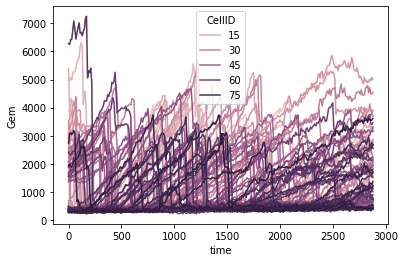

In [4]:
sns.lineplot(data=data_p, x='time', y='Gem',hue='CellID')
plt.savefig('raw_plot_gem.pdf')

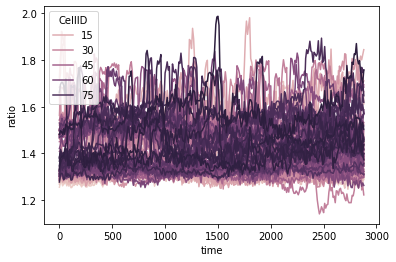

In [5]:
sns.lineplot(data=data_p, x='time', y='ratio',hue='CellID')
plt.savefig('raw_plot_cdk.pdf')

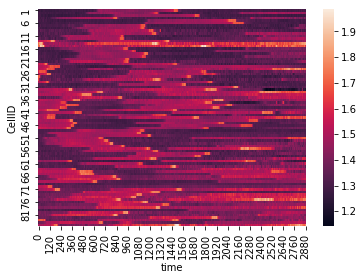

In [6]:
sns.heatmap(data_ratio)
plt.savefig('raw_heatmap_cdk.pdf')
plt.savefig('raw_heatmap_cdk.jpg', bbox_inches='tight', dpi=300)

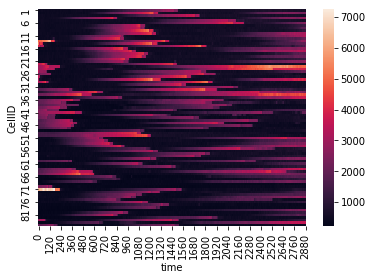

In [7]:
sns.heatmap(data_gem)
plt.savefig('raw_heatmap_gem.pdf')
plt.savefig('raw_heatmap_gem.jpg', bbox_inches='tight', dpi=300)

[142]


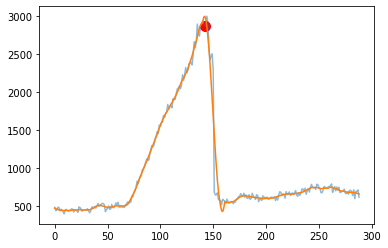

In [8]:
## Test for Geminin peak detection
original = data_gem.iloc[0,:].values
test = signal.savgol_filter(original, 21, 3)
peaks = signal.find_peaks(test, distance =100, height=np.mean(original))
print(peaks[0])

plt.plot(original,alpha=0.5)
plt.plot(test)
plt.scatter(peaks[0], original[peaks[0]], color='red',s=100)
plt.show()

In [9]:
arr_gem = data_gem.values
arr_cdk = signal.savgol_filter(data_ratio.values, 5, 3)
peaks_gem = [signal.find_peaks(signal.savgol_filter(arr_gem[cell], 5, 3), 
                               distance =100, height=np.max(arr_gem[cell])/2)[0] 
             for cell in range(arr_gem.shape[0])]
peaks_gem

[array([144], dtype=int64),
 array([122, 265], dtype=int64),
 array([167], dtype=int64),
 array([ 79, 287], dtype=int64),
 array([203], dtype=int64),
 array([208], dtype=int64),
 array([108], dtype=int64),
 array([108], dtype=int64),
 array([118], dtype=int64),
 array([121, 287], dtype=int64),
 array([ 87, 287], dtype=int64),
 array([86], dtype=int64),
 array([ 12, 135], dtype=int64),
 array([  3, 121], dtype=int64),
 array([  4, 174], dtype=int64),
 array([ 90, 285], dtype=int64),
 array([ 99, 280], dtype=int64),
 array([112], dtype=int64),
 array([110, 280], dtype=int64),
 array([92], dtype=int64),
 array([ 90, 278], dtype=int64),
 array([  5, 143], dtype=int64),
 array([ 10, 249], dtype=int64),
 array([  7, 251], dtype=int64),
 array([  3, 174, 285], dtype=int64),
 array([ 12, 177], dtype=int64),
 array([159], dtype=int64),
 array([122, 285], dtype=int64),
 array([  6, 181], dtype=int64),
 array([152], dtype=int64),
 array([208], dtype=int64),
 array([ 31, 178], dtype=int64),
 array

In [10]:
## aligned at first peak
offset = 300
peak_num_min = 1
aligned_peak_num = 1

arr_gem_aligned = []
arr_cdk_aligned = []
for cell in range(arr_gem.shape[0]):
    if len(peaks_gem[cell]) > peak_num_min -1:
        new_gem = np.insert(arr_gem[cell], 0, np.full(offset-peaks_gem[cell][aligned_peak_num-1],np.nan))
        new_cdk = np.insert(arr_cdk[cell], 0, np.full(offset-peaks_gem[cell][aligned_peak_num-1],np.nan))
        
        new_gem = np.hstack([new_gem, np.full(peaks_gem[cell][aligned_peak_num-1],np.nan)])
        new_cdk = np.hstack([new_cdk, np.full(peaks_gem[cell][aligned_peak_num-1],np.nan)])
        
        arr_gem_aligned.append(new_gem)
        arr_cdk_aligned.append(new_cdk)
        
    else:
        print('no sufficient peaks for cell ID: ' + str(cell))

arr_gem_aligned = pd.DataFrame(arr_gem_aligned)
arr_cdk_aligned = pd.DataFrame(arr_cdk_aligned)

arr_gem_aligned['Num_nan'] = arr_gem_aligned.iloc[:,:300].isnull().values.sum(axis=1)
arr_cdk_aligned['Num_nan'] = arr_cdk_aligned.iloc[:,:300].isnull().values.sum(axis=1)

arr_gem_aligned = arr_gem_aligned.sort_values('Num_nan') 
arr_cdk_aligned = arr_cdk_aligned.sort_values('Num_nan') 

arr_gem_aligned_norm = arr_gem_aligned.copy()
arr_gem_aligned_norm = arr_gem_aligned_norm.T.values/ (arr_gem_aligned_norm.iloc[:,300].values)
arr_gem_aligned_norm = pd.DataFrame(arr_gem_aligned_norm).T

arr_gem_aligned_norm.columns = np.arange(-3010, 2890, 10)
arr_cdk_aligned.columns = np.arange(-3010, 2890, 10)

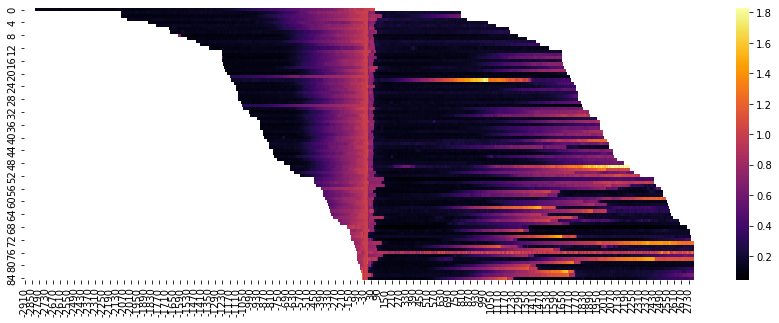

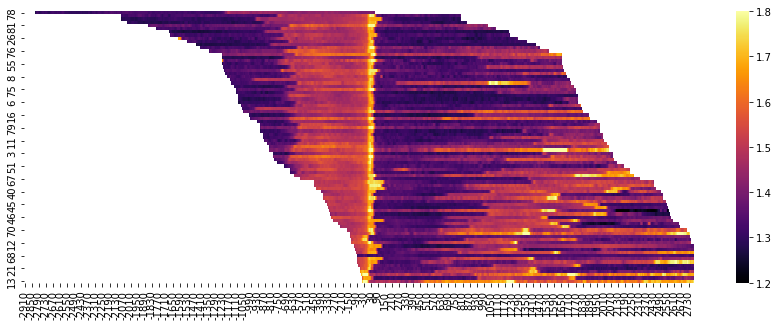

85


In [11]:
plt.figure(figsize=(15,5))
sns.heatmap(arr_gem_aligned_norm.iloc[:,10:-11], cmap='inferno',xticklabels=6)
plt.savefig('M_aligned_heatmap_gem.pdf')
plt.savefig('M_aligned_heatmap_gem.jpg', bbox_inches='tight', dpi=300)
plt.show()
plt.figure(figsize=(15,5))
sns.heatmap(arr_cdk_aligned.iloc[:,10:-11], vmin=1.2,vmax=1.8, cmap='inferno',xticklabels=6)
plt.savefig('M_aligned_heatmap_cdk.pdf')
plt.savefig('M_aligned_heatmap_cdk.jpg', bbox_inches='tight', dpi=300)
plt.show()

print(len(arr_cdk_aligned))

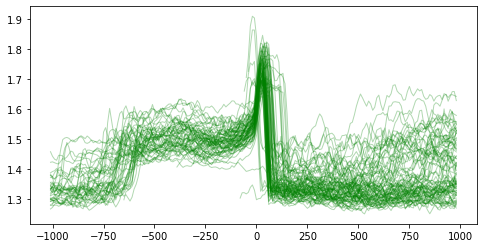

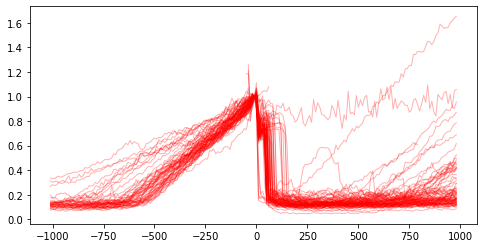

In [12]:
plt.figure(figsize=(8,4))
plt.plot(arr_cdk_aligned.iloc[:,200:400].T, color='green', lw=1, alpha=0.3)
plt.savefig('M_aligned_plot_gem.pdf')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(arr_gem_aligned_norm.iloc[:,200:400].T, color='red', lw=1, alpha=0.3)
plt.savefig('M_aligned_plot_cdk.pdf')
plt.show()

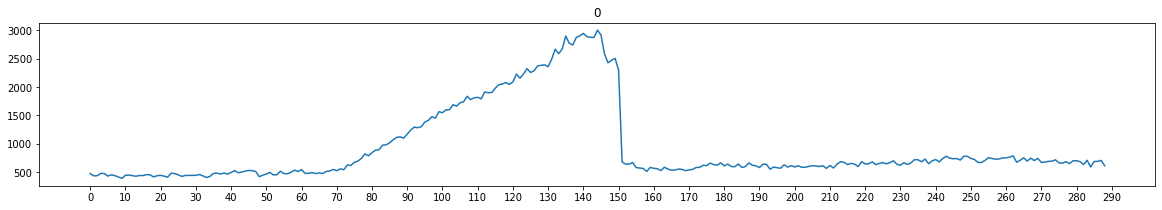

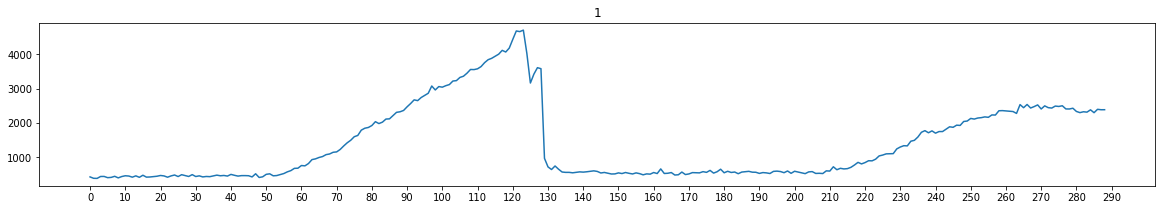

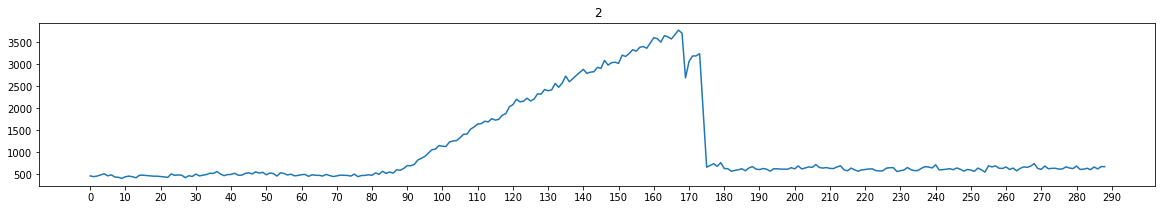

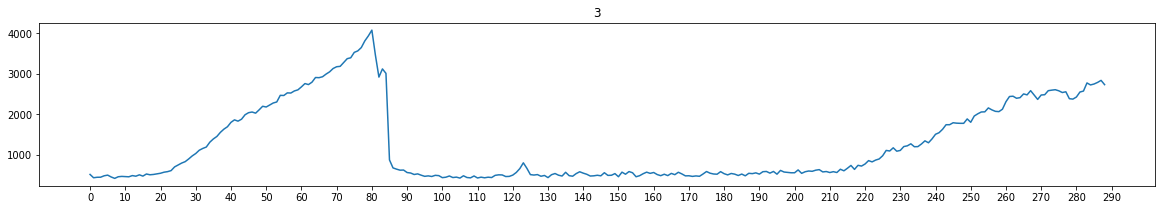

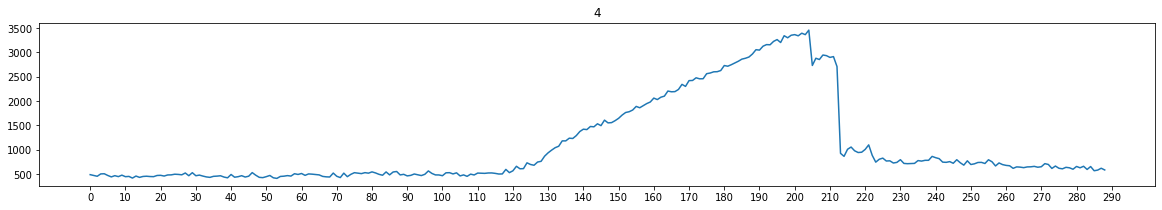

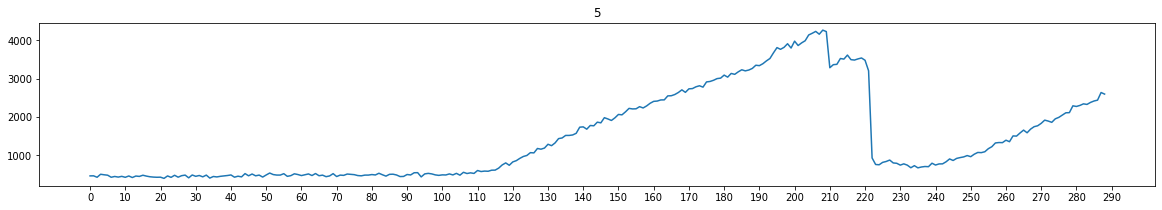

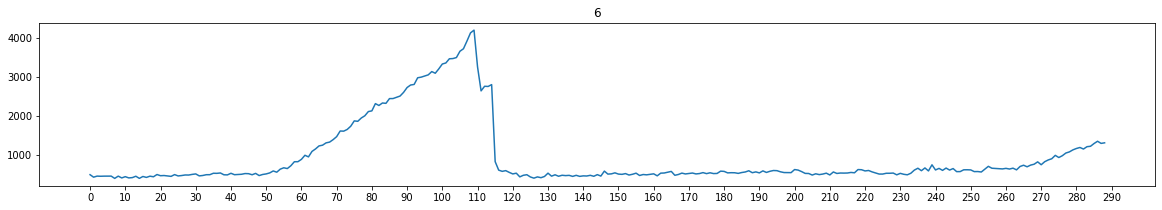

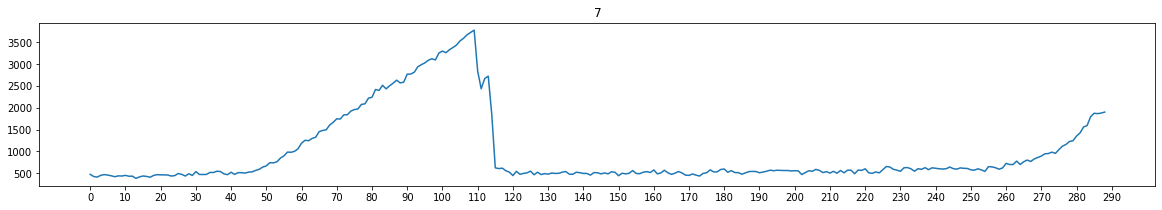

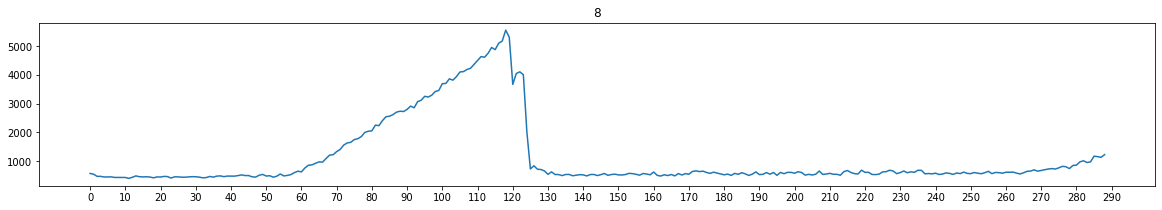

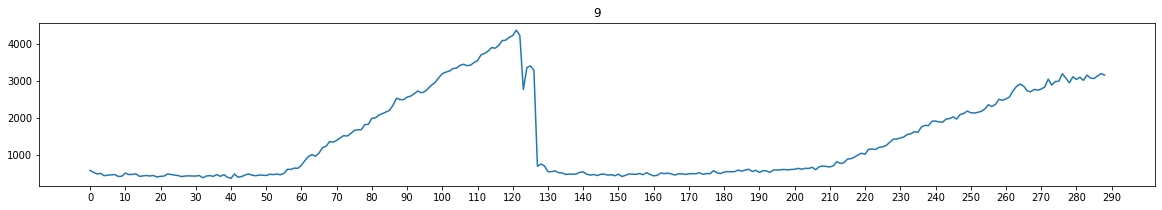

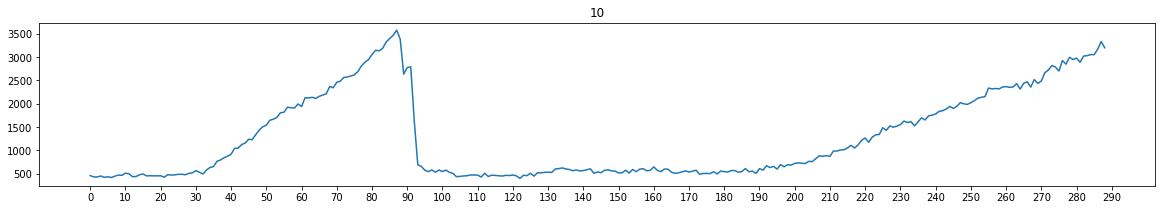

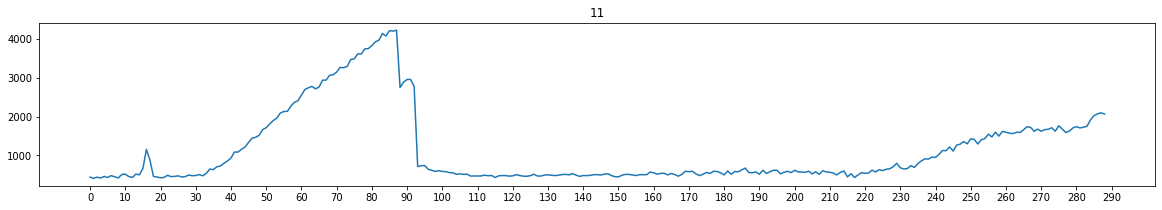

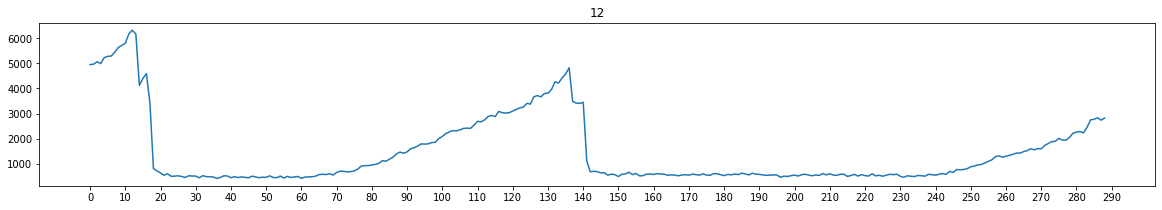

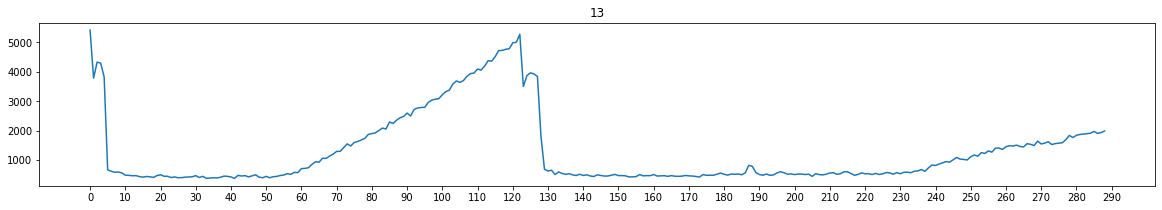

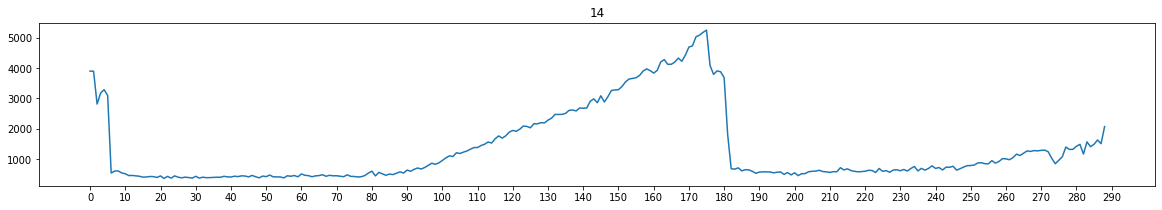

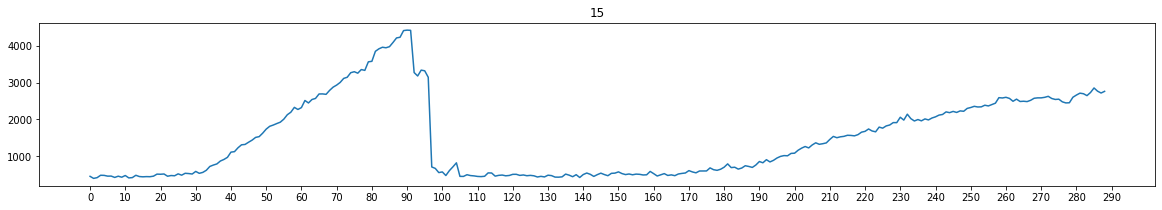

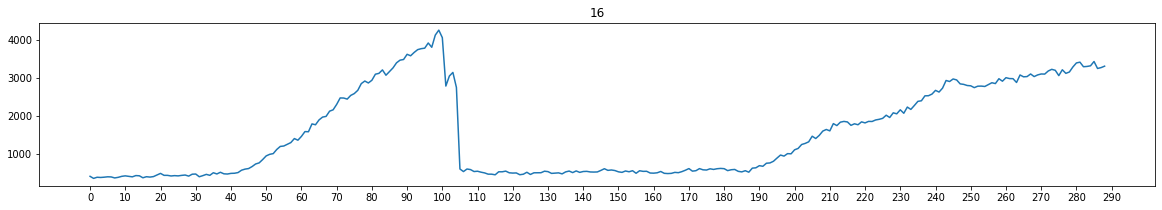

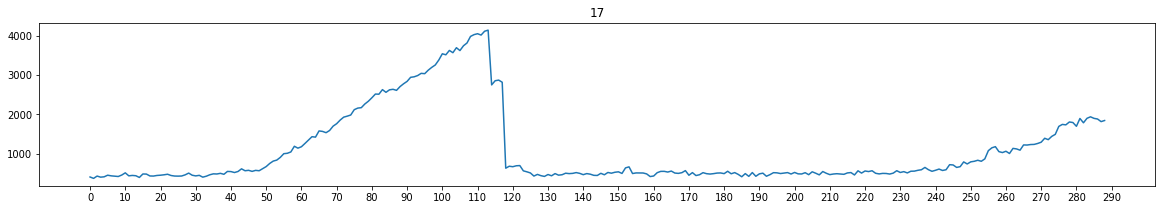

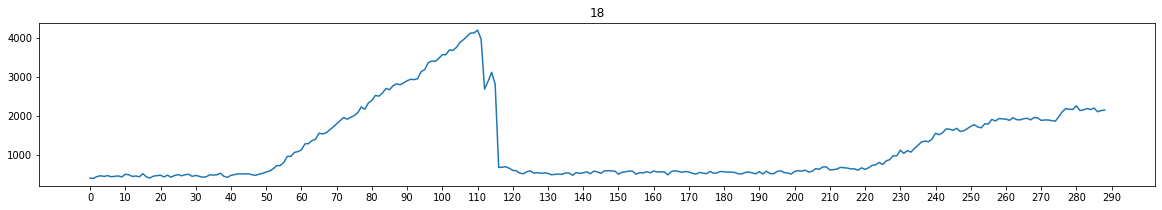

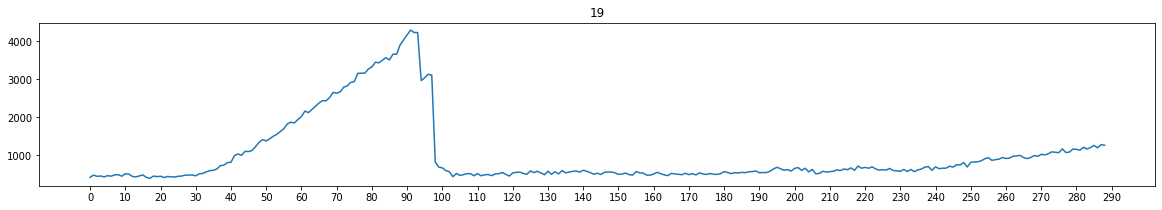

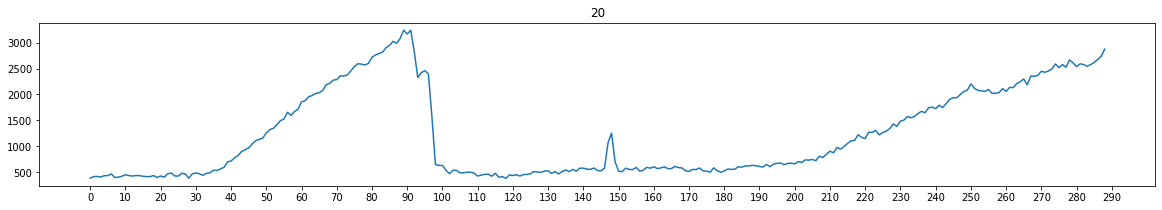

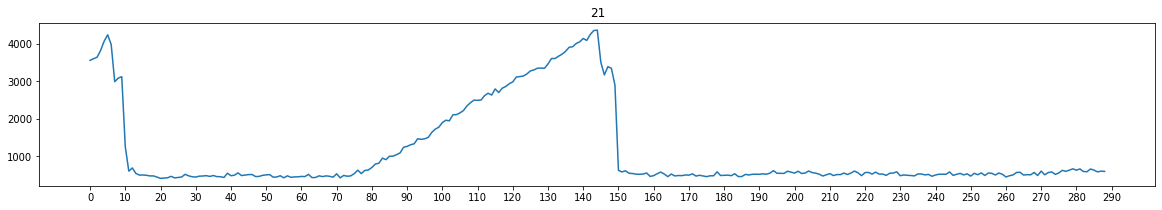

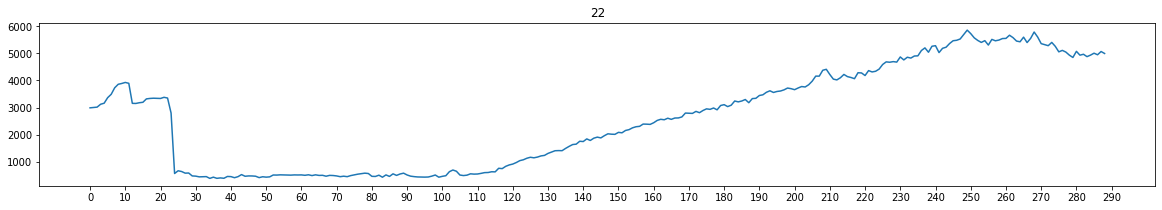

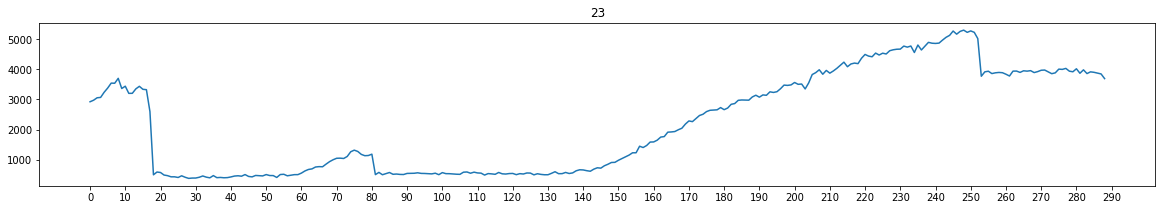

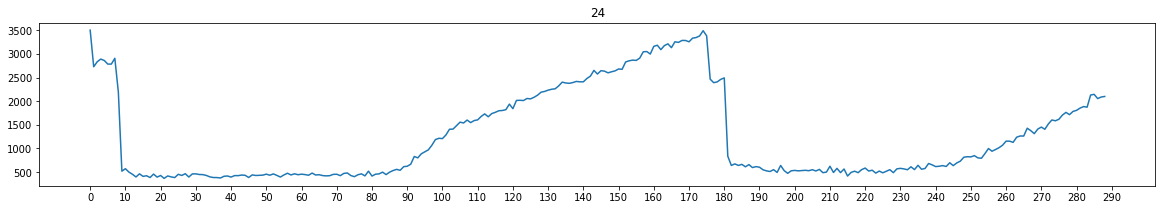

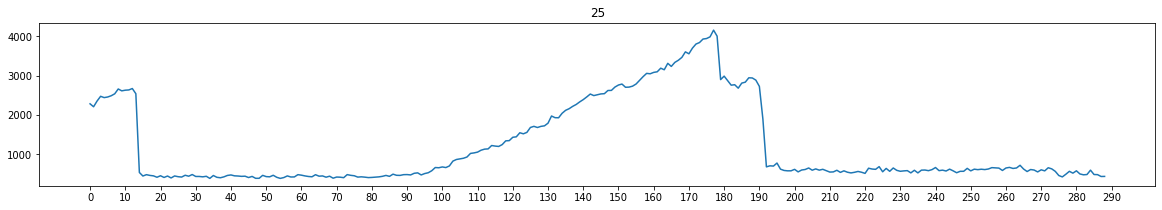

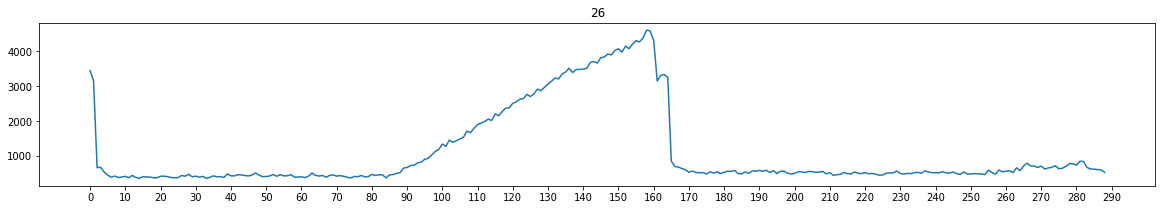

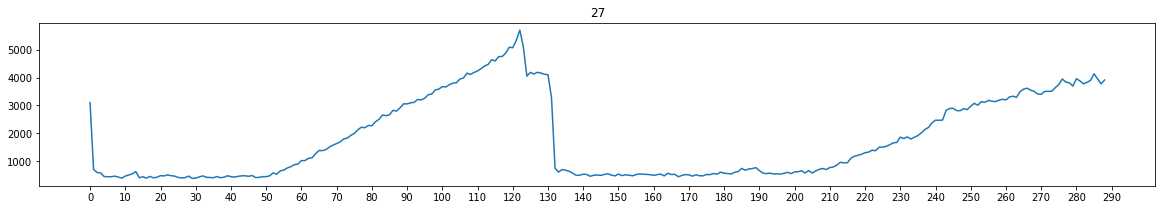

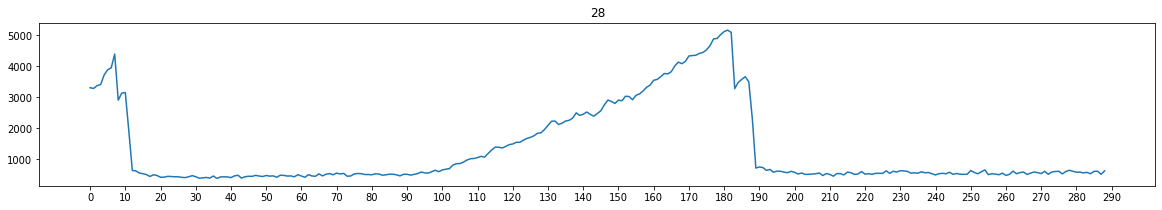

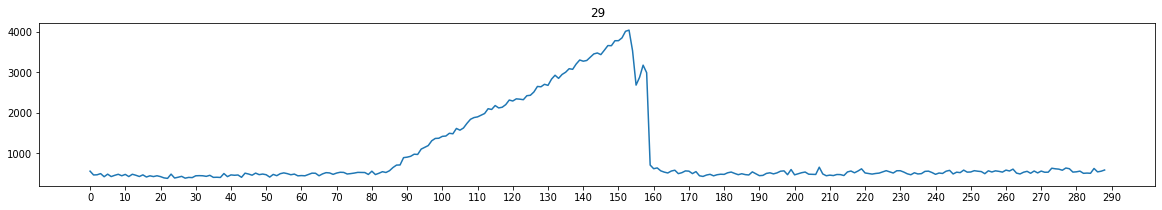

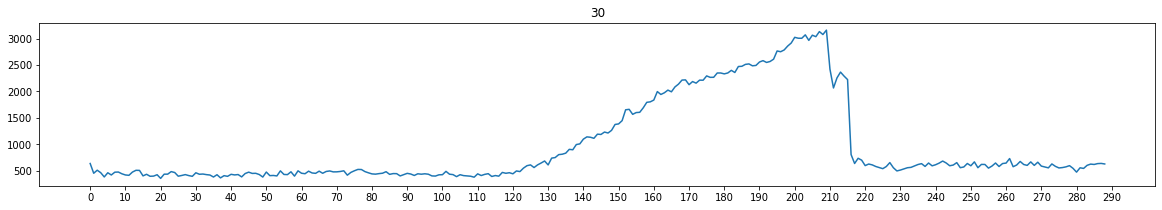

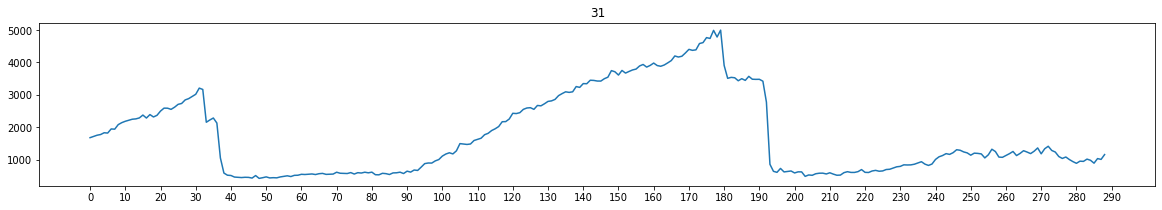

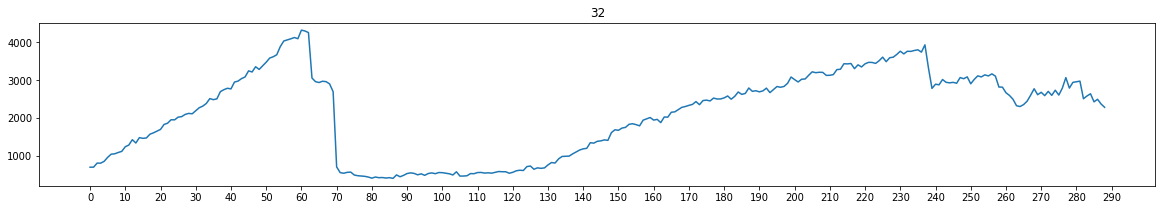

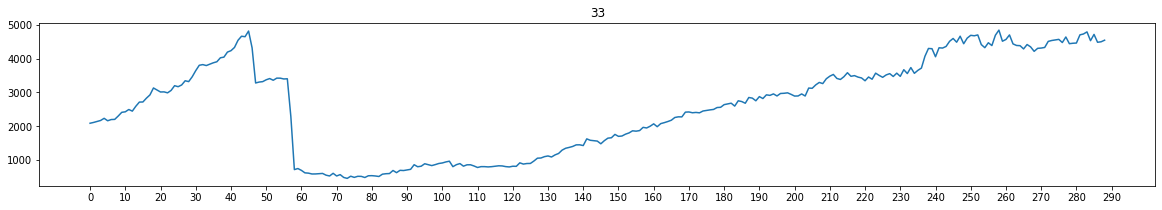

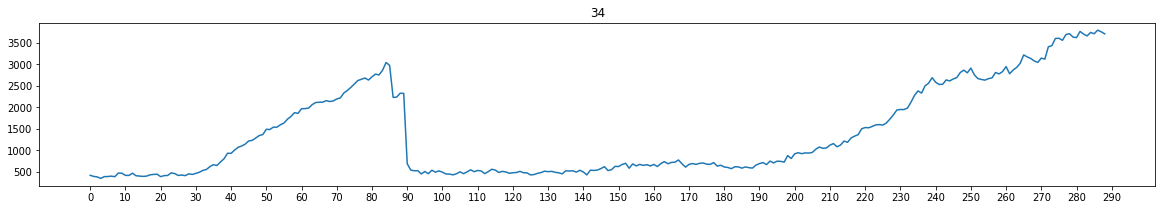

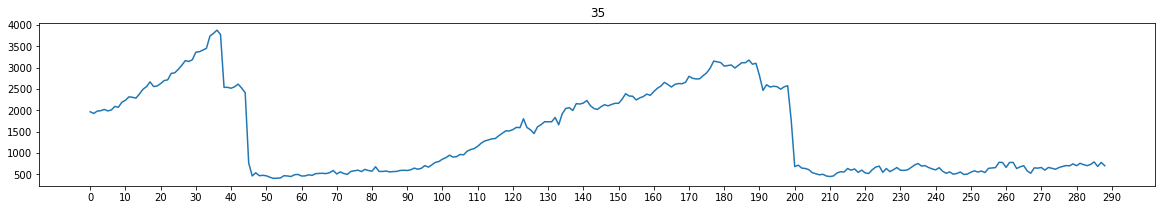

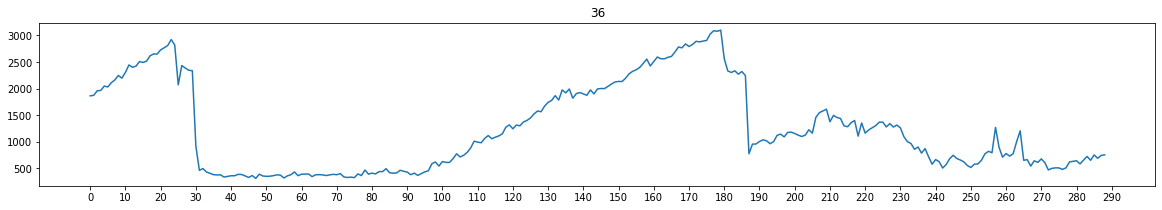

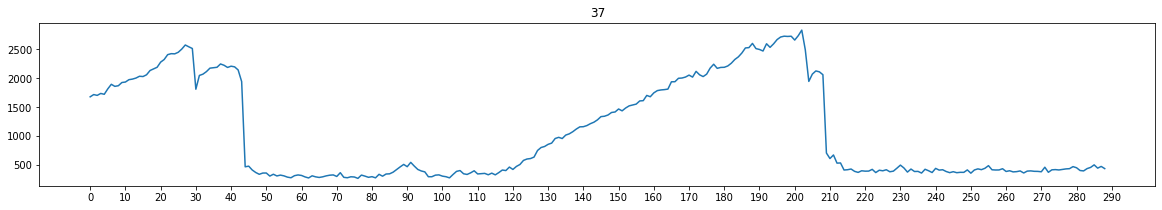

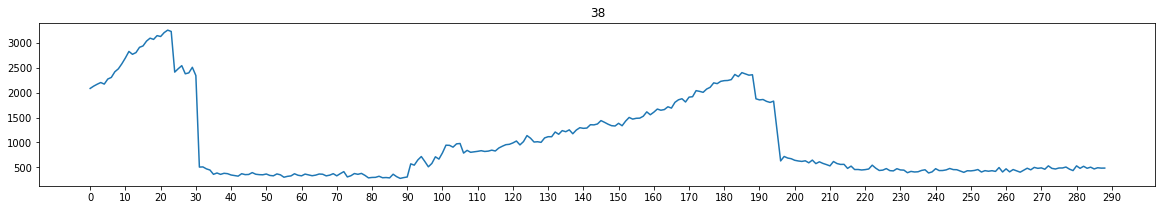

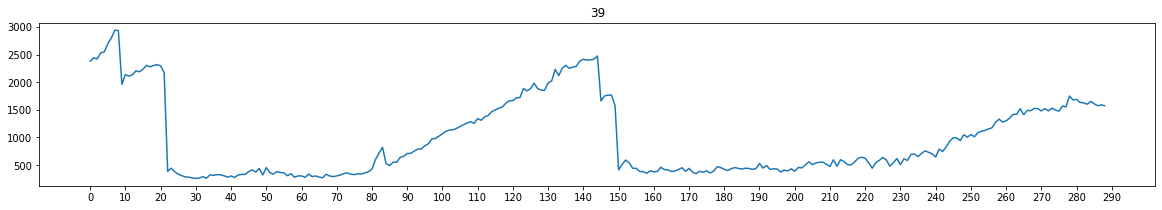

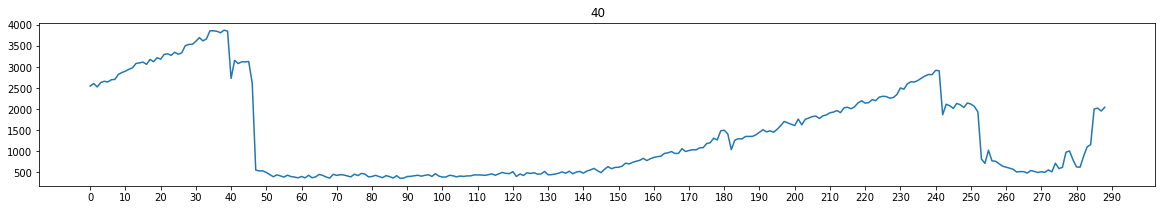

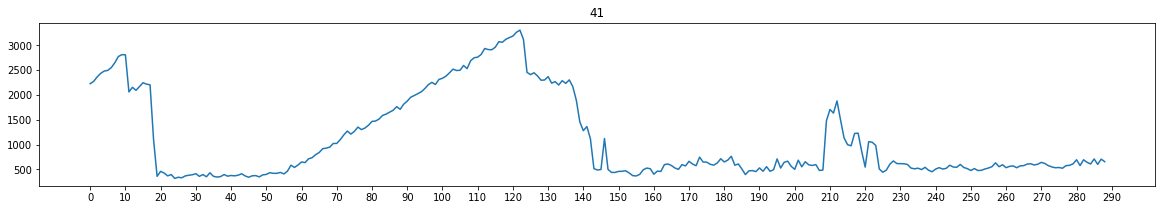

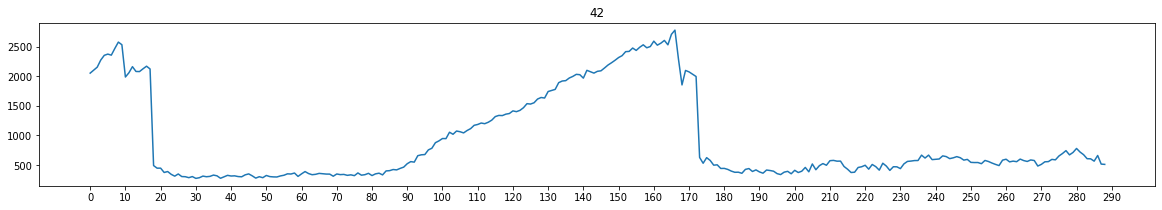

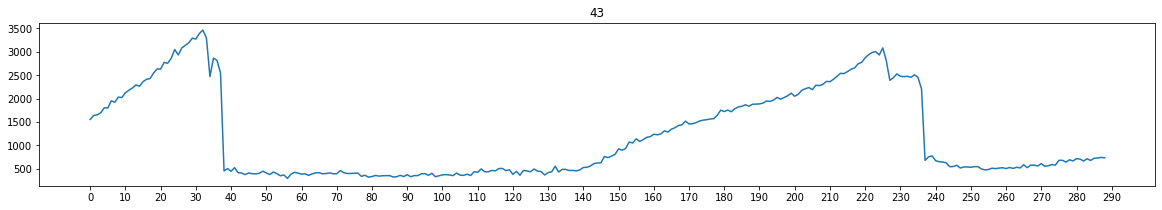

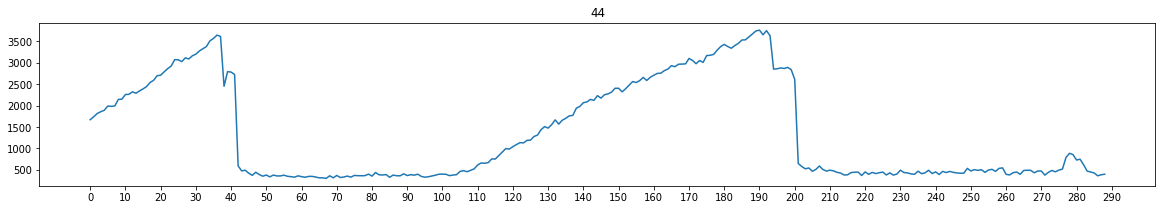

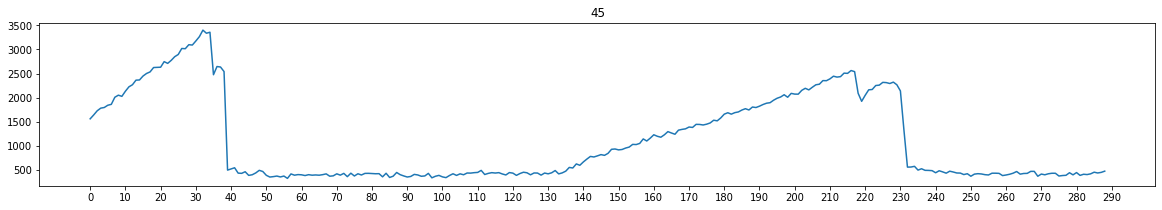

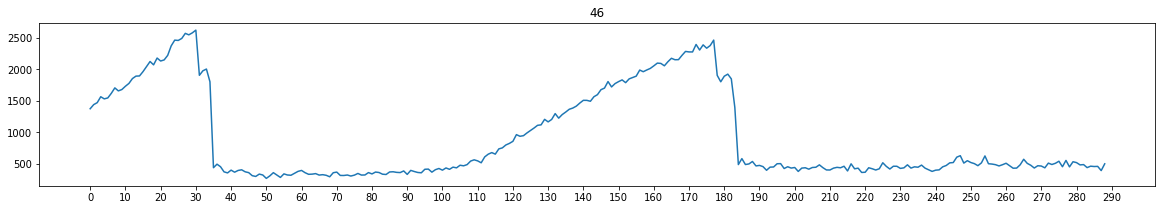

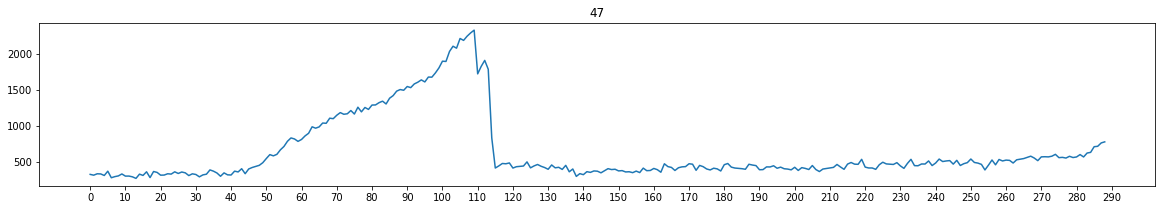

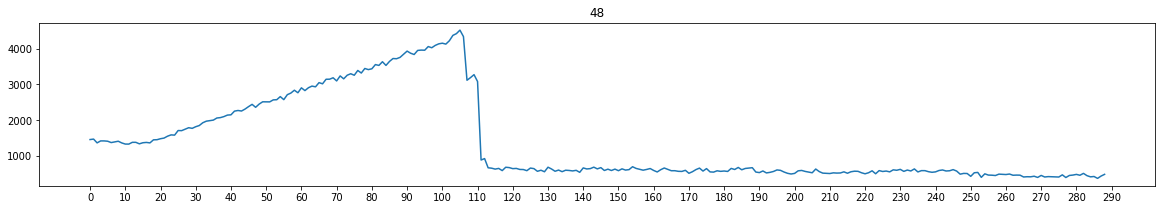

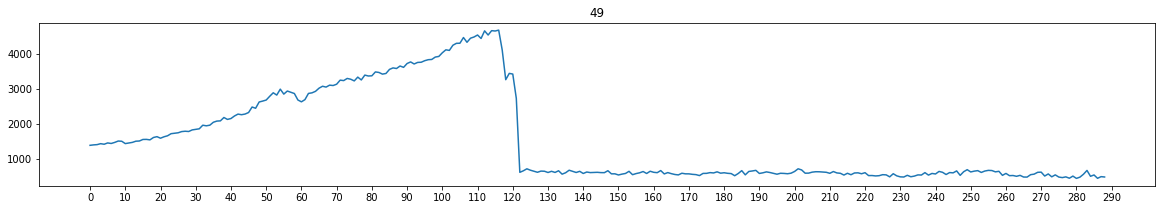

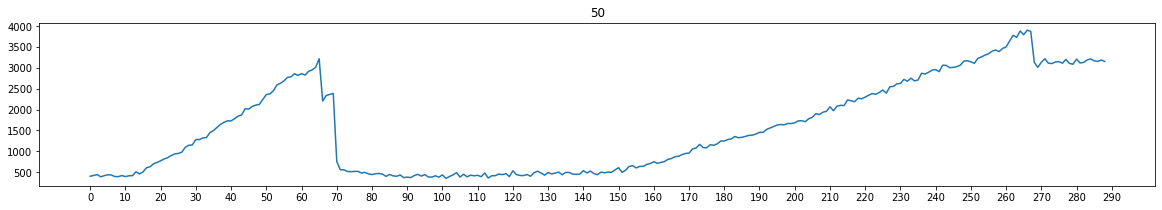

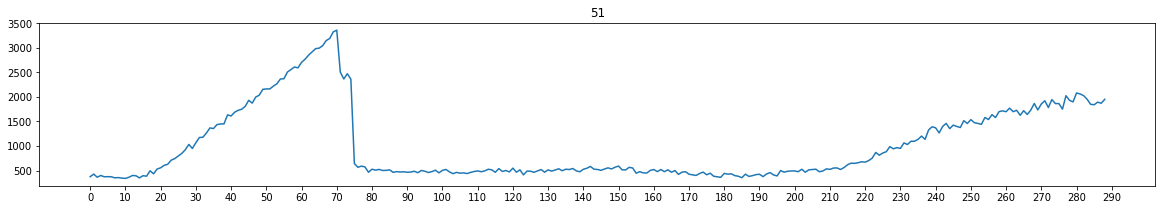

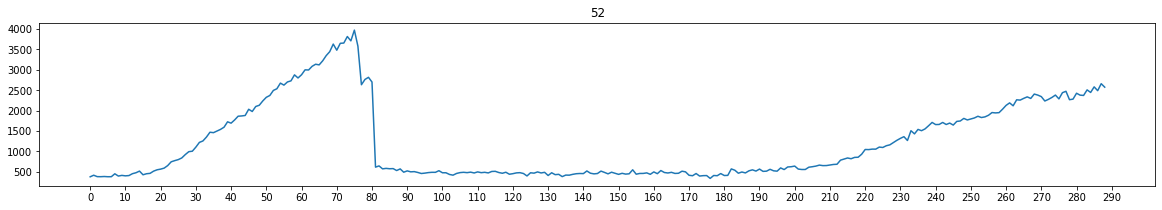

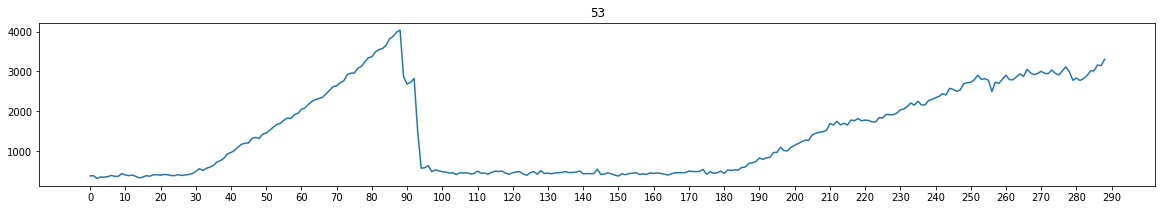

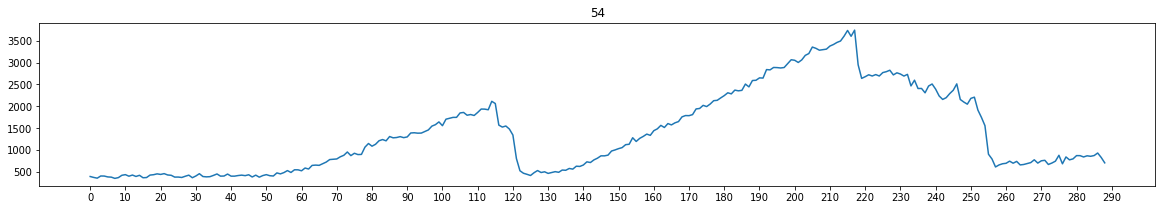

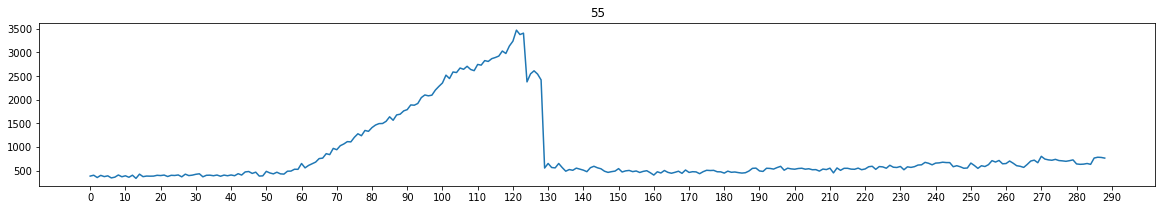

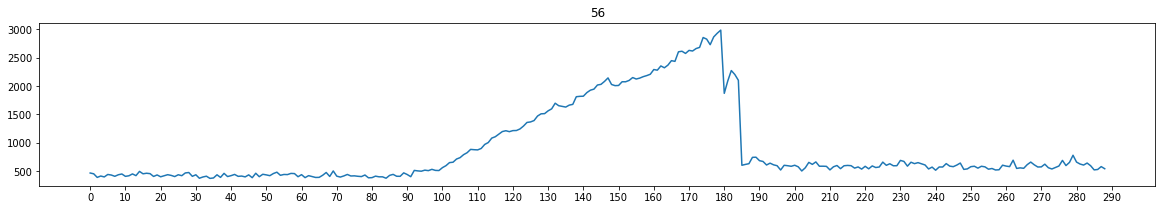

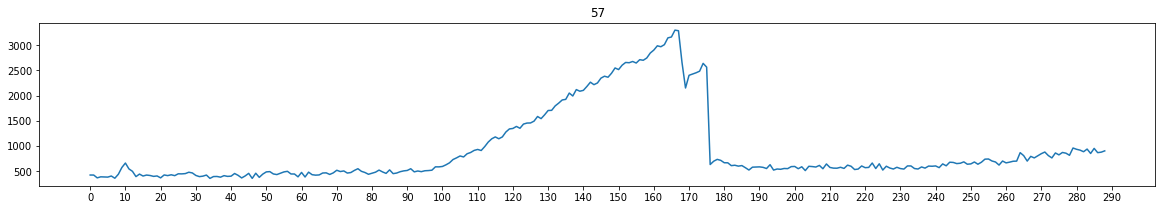

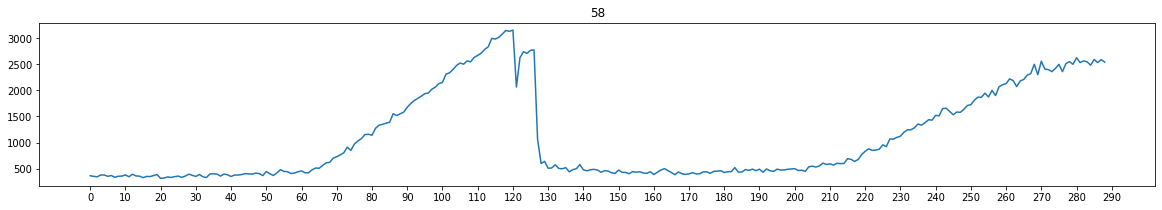

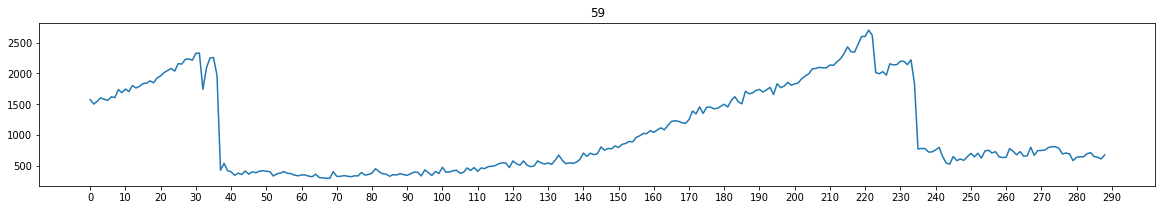

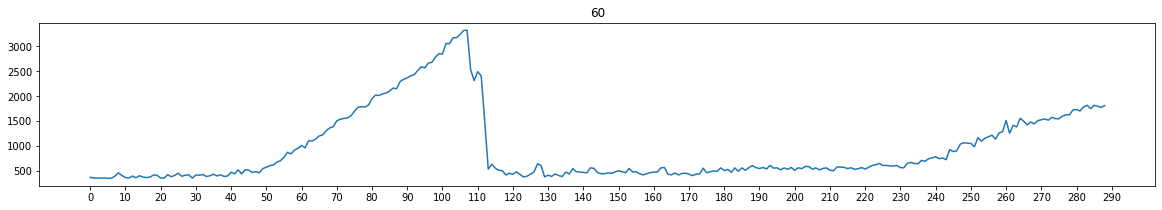

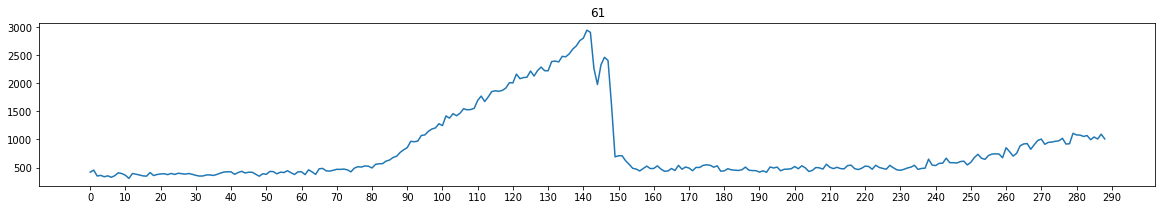

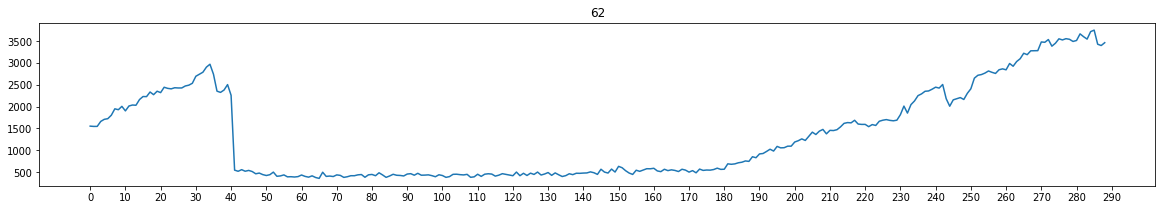

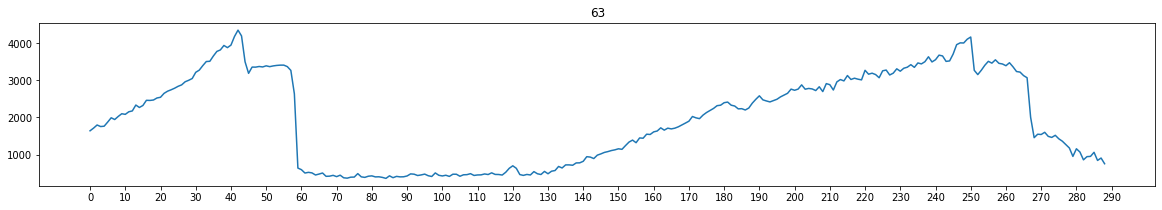

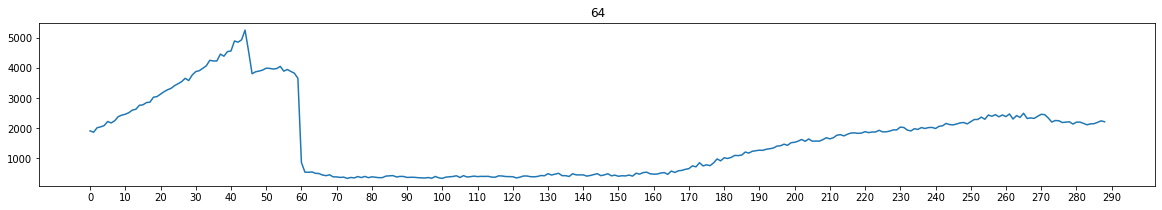

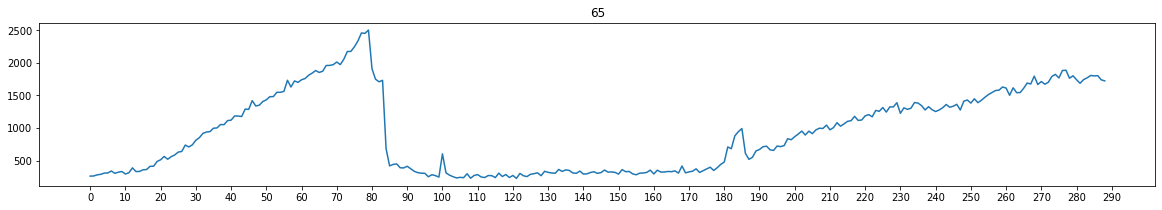

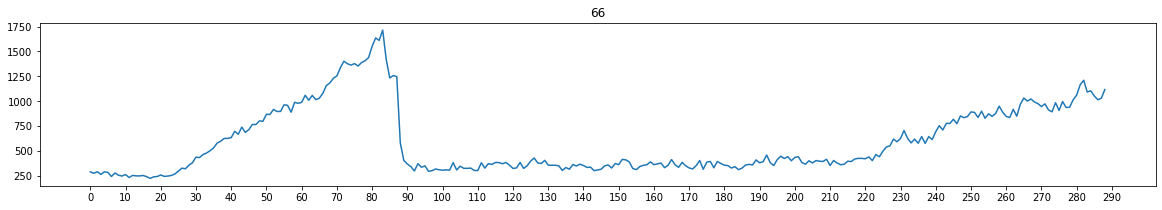

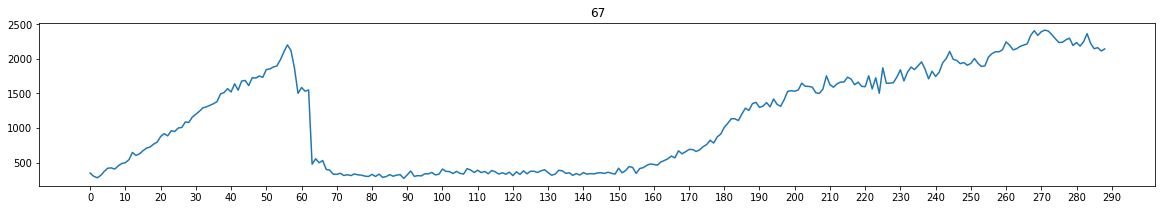

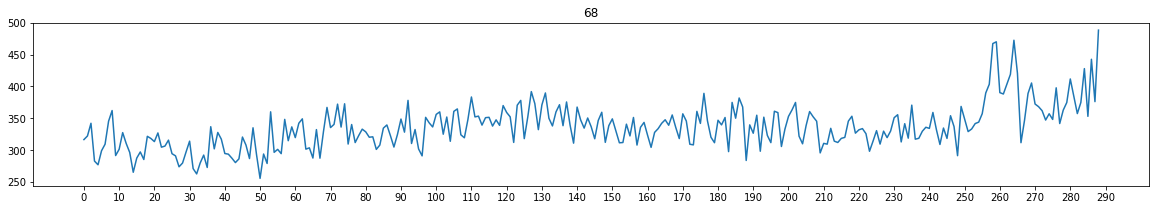

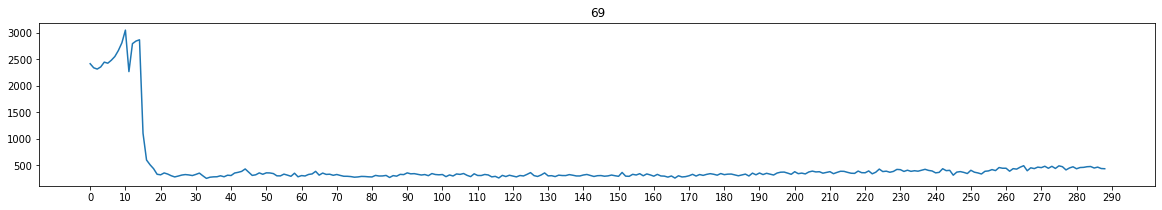

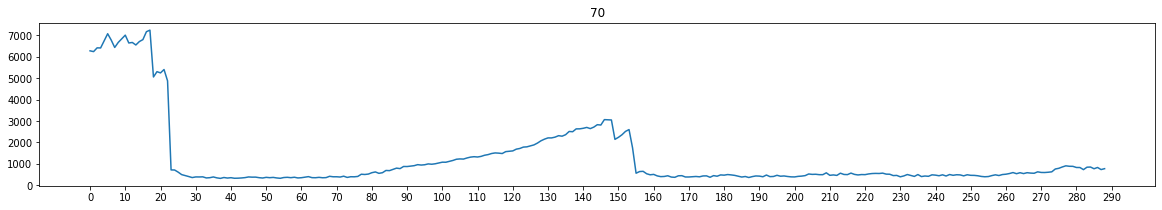

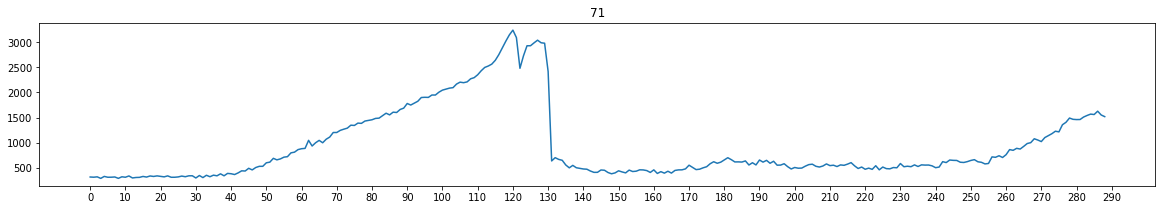

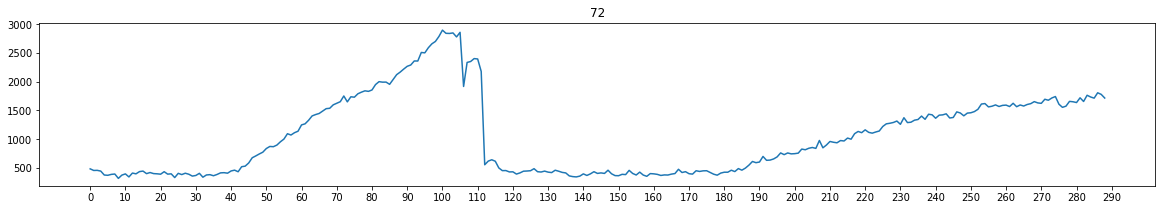

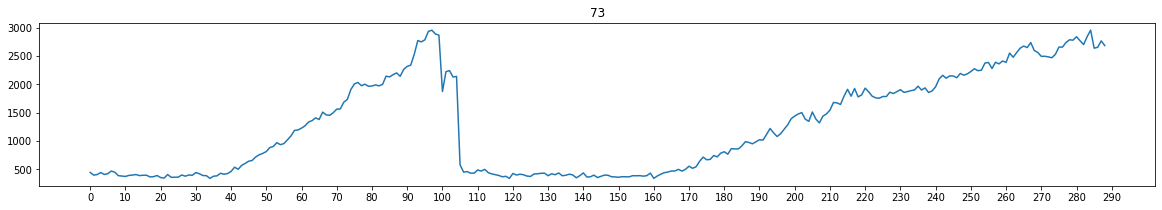

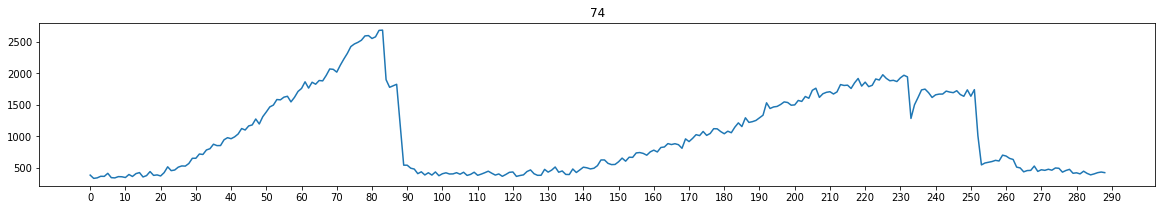

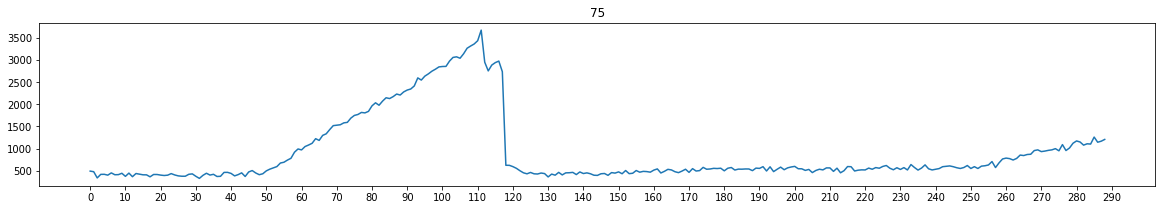

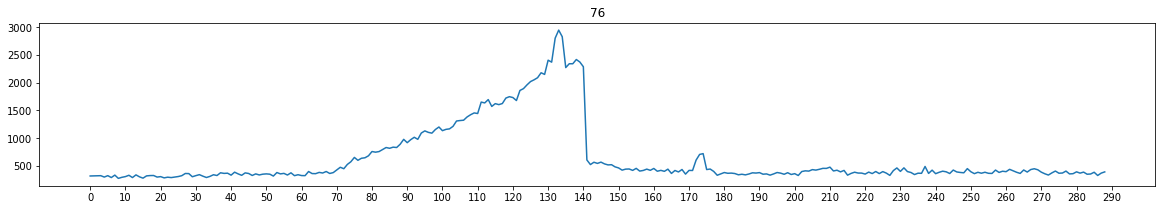

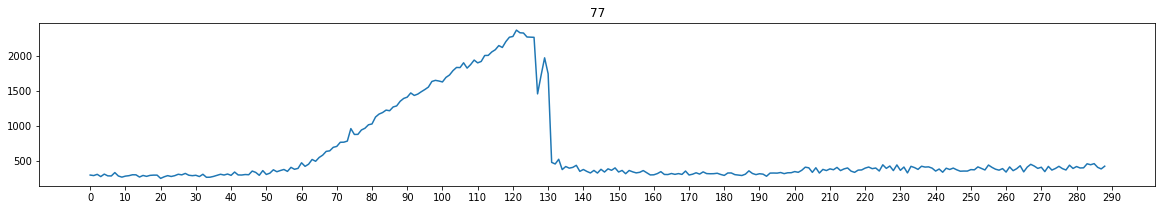

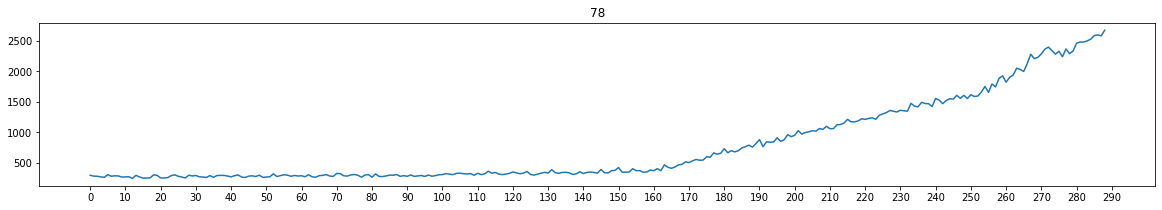

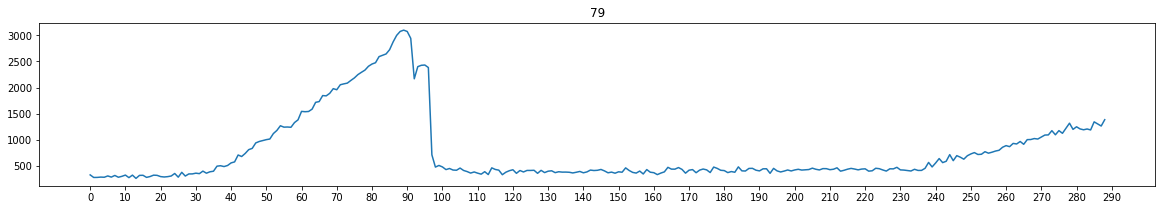

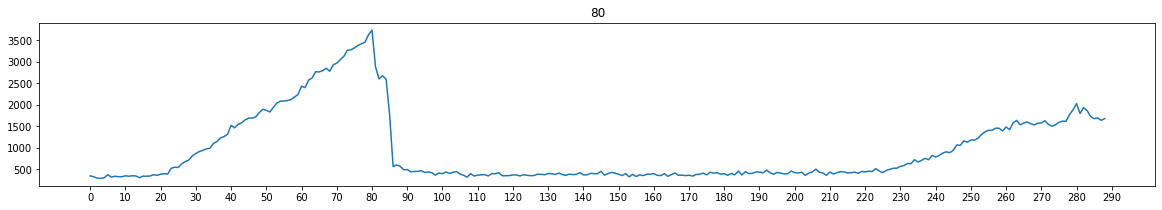

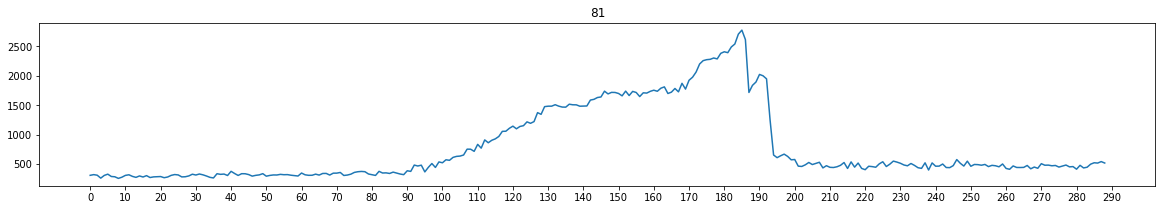

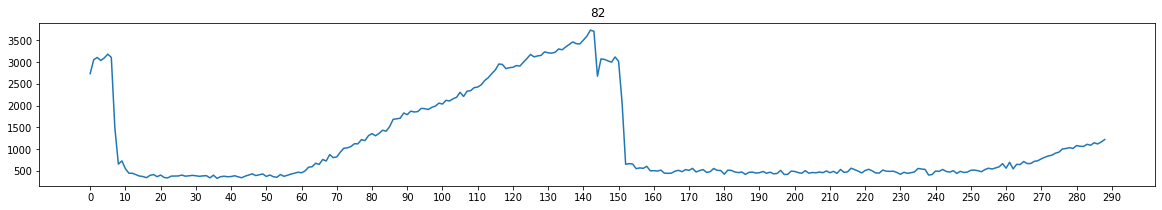

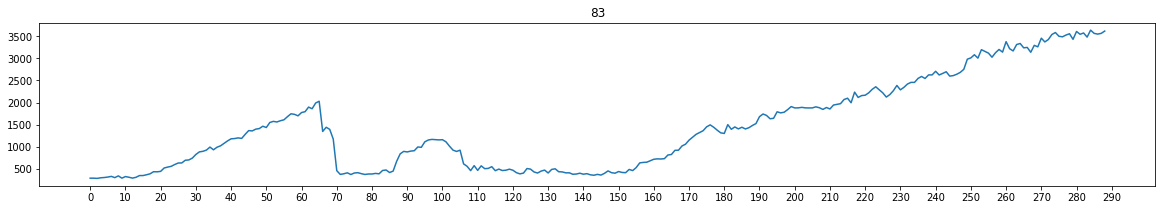

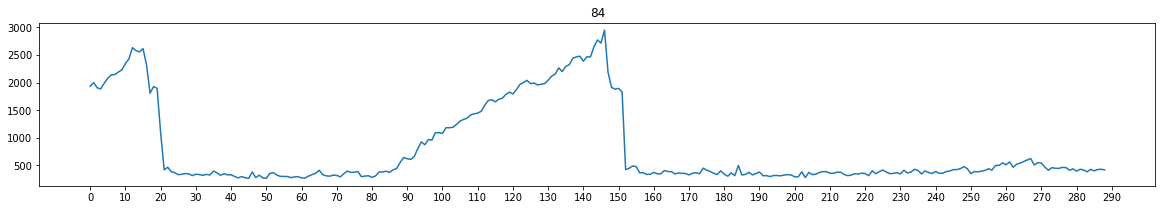

In [13]:
for i in range(len(data_gem)):
    plt.figure(figsize=(20,3))
    plt.plot(arr_gem[i])
    plt.title(i)
    plt.xticks(np.arange(0,300,10))
    plt.show()

In [14]:
Gem_onset =  [[140], [110], [180], [40], [240], [230], [100], [90], [120], [110], 
              [60], [65], [130], [110], [180], [60], [90], [100], [100], [65], 
              [70], [150], [230], [290], [170], [190], [170], [100], [200], [170], 
              [250], [180], [250], [250], [], [190], [190], [240], [180], [160], 
              [290], [110], [170], [270], [210], [270], [210], [90], [], [], 
              [], [], [], [], [110], [110], [200], [200], [130], [260], 
              [100], [160], [], [], [], [], [50], [], [], [], 
              [160], [80], [80], [70], [40], [100], [140], [120], [], [70], 
              [40], [190], [120], [30], [170]] 

In [15]:
## aligned at Gem onset
offset = 300

arr_gem_aligned_s = []
arr_cdk_aligned_s = []
for cell in range(arr_gem.shape[0]):
    if len(Gem_onset[cell]) == 1:
        new_gem = np.insert(arr_gem[cell], 0, np.full(offset-int(Gem_onset[cell][0]/2),np.nan))
        new_cdk = np.insert(arr_cdk[cell], 0, np.full(offset-int(Gem_onset[cell][0]/2),np.nan))
        
        new_gem = np.hstack([new_gem, np.full(int(Gem_onset[cell][0]/2),np.nan)])
        new_cdk = np.hstack([new_cdk, np.full(int(Gem_onset[cell][0]/2),np.nan)])
        
        arr_gem_aligned_s.append(new_gem)
        arr_cdk_aligned_s.append(new_cdk)
        
    else:
        print('no sufficient peaks for cell ID: ' + str(cell))

arr_gem_aligned_s = pd.DataFrame(arr_gem_aligned_s)
arr_cdk_aligned_s = pd.DataFrame(arr_cdk_aligned_s)

arr_gem_aligned_s['Num_nan'] = arr_gem_aligned_s.iloc[:,:300].isnull().values.sum(axis=1)
arr_cdk_aligned_s['Num_nan'] = arr_cdk_aligned_s.iloc[:,:300].isnull().values.sum(axis=1)

arr_gem_aligned_s = arr_gem_aligned_s.sort_values('Num_nan') 
arr_cdk_aligned_s = arr_cdk_aligned_s.sort_values('Num_nan') 

arr_gem_aligned_norm_s = arr_gem_aligned_s.copy()
arr_gem_aligned_norm_s = arr_gem_aligned_norm_s.T.values/ (np.nanmax(arr_gem_aligned_norm_s.iloc[:,300:450].values))
arr_gem_aligned_norm_s = pd.DataFrame(arr_gem_aligned_norm_s).T

arr_gem_aligned_norm_s.columns = np.arange(-3010, 2890, 10)
arr_cdk_aligned_s.columns = np.arange(-3010, 2890, 10)

no sufficient peaks for cell ID: 34
no sufficient peaks for cell ID: 48
no sufficient peaks for cell ID: 49
no sufficient peaks for cell ID: 50
no sufficient peaks for cell ID: 51
no sufficient peaks for cell ID: 52
no sufficient peaks for cell ID: 53
no sufficient peaks for cell ID: 62
no sufficient peaks for cell ID: 63
no sufficient peaks for cell ID: 64
no sufficient peaks for cell ID: 65
no sufficient peaks for cell ID: 67
no sufficient peaks for cell ID: 68
no sufficient peaks for cell ID: 69
no sufficient peaks for cell ID: 78


C:\Users\yuhei goto\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "xticklabels" which is no longer supported as of 3.3 and will become an error in 3.6
  after removing the cwd from sys.path.


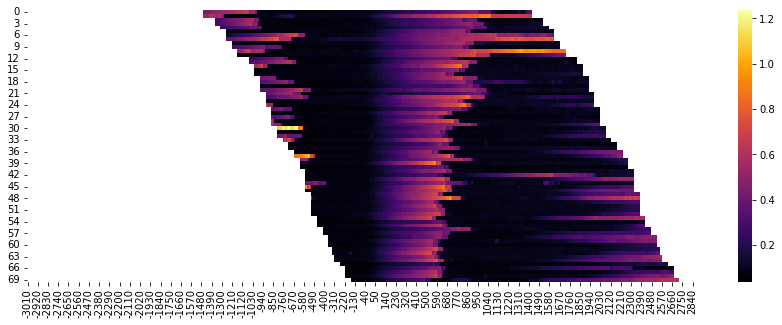

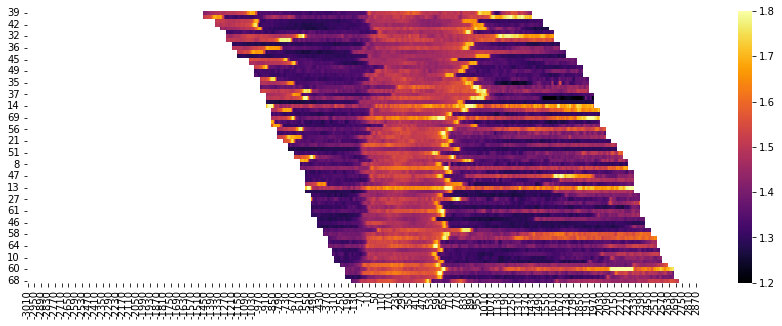

70


In [16]:
plt.figure(figsize=(15,5))
sns.heatmap(arr_gem_aligned_norm_s.iloc[:,:-1], cmap='inferno')
plt.savefig('S_aligned_heatmap_gem.pdf')
plt.savefig('S_aligned_heatmap_gem.jpg', bbox_inches='tight', dpi=300,xticklabels=6)
plt.show()
plt.figure(figsize=(15,5))
sns.heatmap(arr_cdk_aligned_s.iloc[:,:-1], vmin=1.2,vmax=1.8, cmap='inferno',xticklabels=6)
plt.savefig('S_aligned_heatmap_cdk.pdf')
plt.savefig('S_aligned_heatmap_cdk.jpg', bbox_inches='tight', dpi=300)
plt.show()

print(len(arr_cdk_aligned_s))

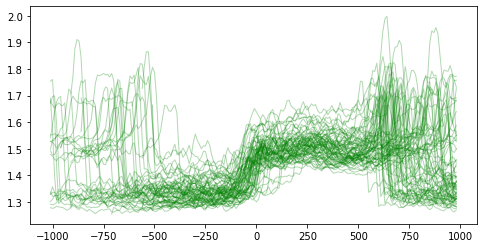

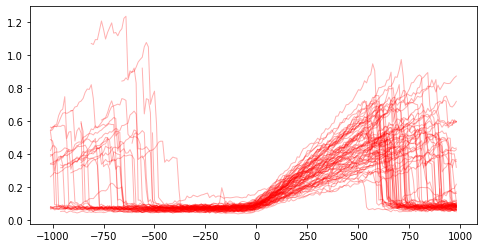

In [17]:
plt.figure(figsize=(8,4))
plt.plot(arr_cdk_aligned_s.iloc[:,200:400].T, color='green', lw=1, alpha=0.3)
plt.savefig('S_aligned_plot_gem.pdf')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(arr_gem_aligned_norm_s.iloc[:,200:400].T, color='red', lw=1, alpha=0.3)
plt.savefig('S_aligned_plot_cdk.pdf')
plt.show()

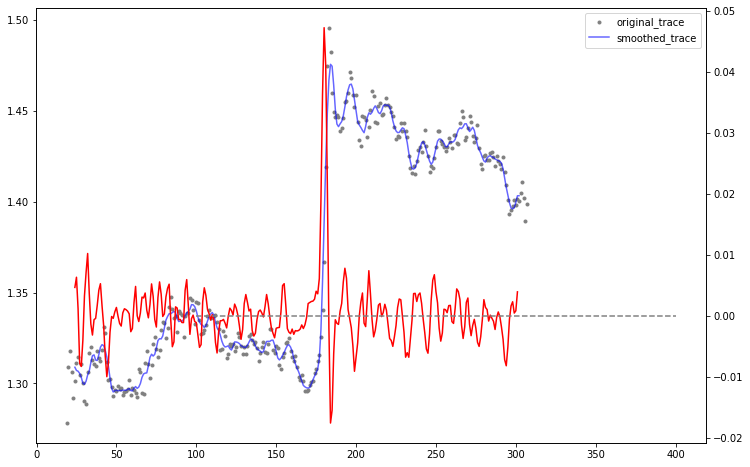

In [18]:
tmp = arr_cdk_aligned.iloc[:,:-100].T.values

for i in range(1):
#for i in range(tmp.shape[1]):
    fig, ax1 = plt.subplots(figsize=(12,8))
    ax2 = ax1.twinx()
    ax1.scatter(np.arange(tmp.shape[0]),tmp[:,i], color='gray', label='original_trace',marker='.')
    ax1.plot(signal.savgol_filter(tmp[:,i], 11,2), color='blue',alpha=0.6, label='smoothed_trace')
    ax2.plot(np.diff(signal.savgol_filter(tmp[:,i], 11,5)), color='red', label='Diff')
    ax2.hlines(0,100,400,ls='--', color='gray')
    ax1.legend()
    plt.show()